<a href="https://colab.research.google.com/github/0mohamed123/IDC-breast-cancer-detection/blob/main/Breast_Cancer_Histopathology_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
from google.colab import files

files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download alaminbhuyan/breast-histopathology-images
!unzip -q breast-histopathology-images.zip -d data/

Dataset URL: https://www.kaggle.com/datasets/alaminbhuyan/breast-histopathology-images
License(s): unknown
 99% 918M/929M [00:16<00:00, 20.2MB/s]
100% 929M/929M [00:16<00:00, 60.4MB/s]


In [26]:
import os
import matplotlib.pyplot as plt
import cv2

In [27]:
path_1 = "data/IDC_regular_ps50_idx5/negative_IDC"
items = os.listdir(path_1)
print(items[:10])

['10288_idx5_x1651_y1501_class0.png', '10260_idx5_x701_y1051_class0.png', '10292_idx5_x101_y1901_class0.png', '12819_idx5_x2851_y601_class0.png', '10258_idx5_x1251_y751_class0.png', '10278_idx5_x3301_y1101_class0.png', '12869_idx5_x1851_y801_class0.png', '10290_idx5_x1701_y1001_class0.png', '12907_idx5_x2001_y551_class0.png', '12890_idx5_x1151_y2451_class0.png']


In [28]:
path_2 = "data/IDC_regular_ps50_idx5/positive_IDC"
items = os.listdir(path_2)
print(items[:10])

['13694_idx5_x1851_y1151_class1.png', '9260_idx5_x151_y551_class1.png', '12909_idx5_x1151_y701_class1.png', '16570_idx5_x2751_y301_class1.png', '16568_idx5_x1951_y951_class1.png', '8864_idx5_x2051_y2701_class1.png', '14190_idx5_x1801_y1251_class1.png', '12242_idx5_x2001_y901_class1.png', '10274_idx5_x1351_y801_class1.png', '15632_idx5_x1601_y1901_class1.png']


In [29]:
cancer_path = "data/IDC_regular_ps50_idx5/positive_IDC/13694_idx5_x1851_y1151_class1.png"
normal_path = "data/IDC_regular_ps50_idx5/negative_IDC/10288_idx5_x1651_y1501_class0.png"

In [30]:
normal_img = cv2.imread(normal_path)
cancer_img = cv2.imread(cancer_path)

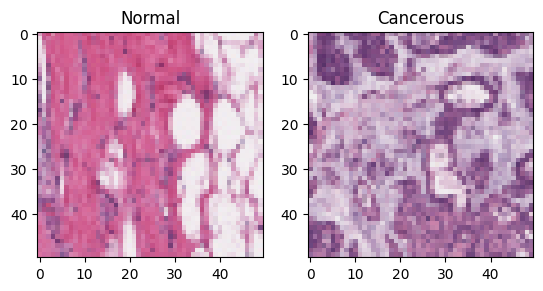

In [31]:
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(normal_img, cv2.COLOR_BGR2RGB)); plt.title("Normal")
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(cancer_img, cv2.COLOR_BGR2RGB)); plt.title("Cancerous")
plt.show()

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split

In [33]:
IMG_SIZE = 50


def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append(img)
            labels.append(label)
    return images, labels

In [34]:
normal_images, normal_labels = load_images_from_folder(path_1, 0)

In [35]:
cancer_images, cancer_labels = load_images_from_folder(path_2, 1)

In [36]:
X = np.array(normal_images + cancer_images)
y = np.array(normal_labels + cancer_labels)

In [37]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [38]:
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [39]:
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (126057, 50, 50, 3) (126057,)
Validation: (15757, 50, 50, 3) (15757,)
Test: (15758, 50, 50, 3) (15758,)


In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [41]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [43]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,649 (1.36 MB)

 Trainable params: 355,649 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
batch_size = 32
epochs = 10

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=epochs
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 610s 154ms/step - accuracy: 0.7564 - loss: 0.5087 - val_accuracy: 0.8187 - val_loss: 0.4121
Epoch 2/10
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 582s 148ms/step - accuracy: 0.8302 - loss: 0.3926 - val_accuracy: 0.8556 - val_loss: 0.3460
Epoch 3/10
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 627s 149ms/step - accuracy: 0.8483 - loss: 0.3591 - val_accuracy: 0.8491 - val_loss: 0.3576
Epoch 4/10
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 575s 146ms/step - accuracy: 0.8517 - loss: 0.3475 - val_accuracy: 0.8557 - val_loss: 0.3403
Epoch 5/10
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 580s 147ms/step - accuracy: 0.8592 - loss: 0.3347 - val_accuracy: 0.8659 - val_loss: 0.3199
Epoch 6/10
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 621s 158ms/step - accuracy: 0.8611 - loss: 0.3308 - val_accuracy: 0.8683 - val_loss: 0.3147
Epoch 7/10
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 576s 146ms/step - accuracy: 0.8641 - loss: 0.3227 - val_accuracy: 0.8629 - val_loss: 0.3197
Epoch 8/10
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 573s 145ms/step - ac

In [45]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

493/493 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.8710 - loss: 0.3172
Test Accuracy: 0.8668612837791443


In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [47]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

493/493 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step


In [48]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[6549 1330]
 [ 768 7111]]


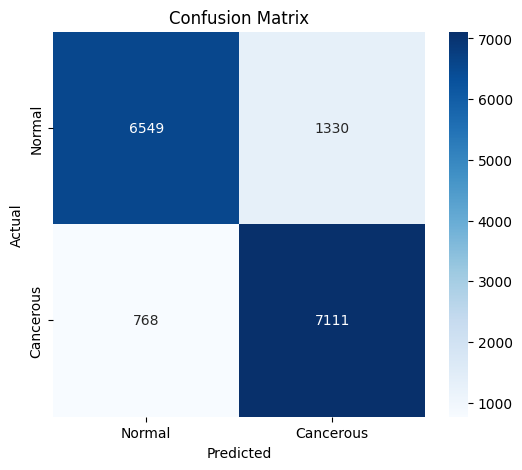

In [49]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Cancerous'], yticklabels=['Normal','Cancerous'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [50]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal','Cancerous']))


Classification Report:
              precision    recall  f1-score   support

      Normal       0.90      0.83      0.86      7879
   Cancerous       0.84      0.90      0.87      7879

    accuracy                           0.87     15758
   macro avg       0.87      0.87      0.87     15758
weighted avg       0.87      0.87      0.87     15758

